# Interpretting PCAs of Top Components

In [1]:
# Loading necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display, Markdown, Latex
import pickle as pk

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import shap

In [72]:
# Import data

data = pd.read_csv('cleaned_data.csv', low_memory=False)

In [73]:
# We will be evaluating only on train

Train = pd.read_csv('./Train_Validation_Test/TRUE_TRAIN.csv')

In [74]:
# ALL COLUMNS

Train.columns

Index(['artist_name', 'percentage of males', '% of children', '% of teenager',
       '% of adult', '% of senior', 'unique_listener', 'listened_count',
       'artist_passion_score', 'Playlist Passion Score', 'Success',
       'region_PCA1', 'region_PCA2', 'region_PCA3', 'region_PCA4',
       'region_PCA5', 'p_PCA1', 'p_PCA2', 'p_PCA3', 'p_PCA4', 'p_PCA5',
       'p_PCA6', 'p_PCA7', 'p_PCA8', 'p_PCA9', 'p_PCA10', 'audio_PCA1',
       'audio_PCA2', 'audio_PCA3', 'audio_PCA4', 'audio_PCA5', 'audio_PCA6',
       'audio_PCA7', 'audio_PCA8', 'audio_PCA9', 'lyrics_PCA1', 'lyrics_PCA2',
       'lyrics_PCA3', 'lyrics_PCA4', 'lyrics_PCA5', 'lyrics_PCA6',
       'lyrics_PCA7', 'lyrics_PCA8', 'lyrics_PCA9'],
      dtype='object')

# Playlist Streams (ALL OF THEM REFER TO P_PCA1)

In [28]:
i_playlist_pca1 = Train[['artist_name','p_PCA1']].copy()

In [31]:
i_playlist_pca2 = pd.read_csv('./Interpretability_PCA/pca_with_columns_intact.csv') # 2 refers to the next dataframe, not PCA component 2!

In [32]:
i_playlist_pca3 = i_playlist_pca1.merge(i_playlist_pca2, how='left', on='artist_name')

In [35]:
i_playlist_pca4 = i_playlist_pca3.corr()

In [69]:
# i_playlist_pca4.sort_values('p_PCA1', ascending=False, inplace=True)
i_playlist_pca5 = i_playlist_pca4.iloc[1:21, 0].to_frame().reset_index()
i_playlist_pca5.columns = ['playlist_id', 'correlations_with_pPCA1']

In [70]:
data_playlist_ids = data[['playlist_id', 'playlist_name']].drop_duplicates().copy()

In [80]:
twenty_important_playlists = i_playlist_pca5.merge(data_playlist_ids, how='left', on='playlist_id')
twenty_important_playlists

,playlist_id,correlations_with_pPCA1,playlist_name
0,3i7JbR7hRltgyEeUWY42b3,0.988489,Top Tracks in France
1,6T7asJNU7aJKbEOTvtPKp0,0.986187,UK Top 40 | 2017
2,6zebVLpv0OiyX58u6DxIbR,0.985686,Chart Hits
3,0KIRSQjaLFtDUsNz8jN0r0,0.985438,ÉXITOS 2017 ABRIL - APRIL HITS - Shakira Me En...
4,7qfB2KGVfhUpFhjK5Lnxr0,0.985228,#Roadtrip
5,1na3xPno8REJmK4n79ryfk,0.985135,HITS DE L'ETE
6,0KdA1BgH4ovIa0vi8YEqRv,0.985135,NaN
7,0rmxqVGbsBjP5oiFAyFnY3,0.982145,1-Pop/R&B/Club/Party/Rap Updated Daily.
8,6PPNsigk3bAKP1fCqnYQ5z,0.981384,IM JUST A SUCKER FOR PAIN.
9,6dm9jZ2p8iGGTLre7nY4hf,0.981251,"BREAKUP SONGS ""Let it all out"" by FILTR"


# Region

In [183]:
i_region_pca1_v1 = Train[['artist_name','region_PCA1']].copy()

In [184]:
i_region_pca1_v2 = pd.read_csv('./Interpretability_PCA/region_pca_with_columns_intact.csv')

In [185]:
i_region_pca1_v3 = i_region_pca1_v1.merge(i_region_pca1_v2, how='left', on='artist_name')

In [186]:
# rows to later drop

def rows_to_drop_region(df):
    reg = []
    streams = []
    for i in df.columns[2:]:
        reg.append(i)
        streams.append(df[i].sum())
    df2 = pd.DataFrame({'region': reg,'streams': streams})
    return df2

filter_region = rows_to_drop_region(i_region_pca1_v3)

In [187]:
i_region_pca1_v4 = i_region_pca1_v3.corr()

In [188]:
# Filter
filter_region_list = filter_region[filter_region.streams > 10000]['region'].to_list()

In [189]:
len(filter_region_list)

65

In [190]:
i_region_pca1_v4.sort_values('region_PCA1', ascending=False, inplace=True)
i_region_pca1_v5 = i_region_pca1_v4.iloc[:, 0].to_frame().reset_index()
i_region_pca1_v5.columns = ['region', 'correlations_with_region_PCA1']
i_region_pca1_v5_filtered = i_region_pca1_v5[i_region_pca1_v5.region.isin(filter_region_list)]

In [287]:
temp = i_region_pca1_v5_filtered.iloc[1:11, :].copy()
temp['region_actual'] = ['Warwick', 'West Sussex', 'Birmingham', 'Kent', 'Cambridgeshire', 
                         'Glasgow City', 'Somerset', 'Brighton and Hove', 'Norfolk', 'Chelsea']
temp[['region', 'region_actual']]

,region,region_actual
6,GB-WAR,Warwick
9,GB-WSX,West Sussex
10,GB-BMH,Birmingham
12,GB-KEN,Kent
14,GB-CAM,Cambridgeshire
15,GB-GLG,Glasgow City
16,GB-SOM,Somerset
19,GB-BNH,Brighton and Hove
21,GB-NFK,Norfolk
22,GB-CHE,Chelsea


# Audio Features

In [223]:
i_audio_pca7_v1 = Train[['artist_name','audio_PCA7']].copy()

In [227]:
i_audio_pca7_v1

,artist_name,audio_PCA7
0,Full,-3.688910
1,Darline,-3.203420
2,Sweem,-3.423136
3,Hovey Benjamin,-3.621873
4,Thomas,-3.634825
...,...,...
470,Endor,2.975604
471,Dan Owen,-1.515518
472,ALP,-3.633525
473,Kazumi Watanabe,-3.621873


## Loudness

In [228]:
i_audio_pca7_v2 = pd.read_csv('./Interpretability_PCA/loudness_PCA_interpret.csv')

In [230]:
i_audio_pca7_v3 = i_audio_pca7_v1.merge(i_audio_pca7_v2, how='left', on='artist_name')

In [231]:
i_audio_pca7_v4 = i_audio_pca7_v3.corr()

In [237]:
i_audio_pca7_v4.sort_values('audio_PCA7', ascending=False, inplace=True)
i_audio_pca7_v5 = i_audio_pca7_v4.iloc[1:21, 0].to_frame().reset_index()
i_audio_pca7_v5.columns = ['playlist_id', 'correlations_with_audio_PCA7']

In [240]:
i_audio_pca7_v6 = i_audio_pca7_v5.merge(data_playlist_ids, how='left', on='playlist_id')
i_audio_pca7_v6

,playlist_id,correlations_with_audio_PCA7,playlist_name
0,0jwrUmA1q2XedkzDBvoHC4,0.174840,Suicide Squad: The Playlist
1,37i9dQZF1DXbEm2sKzgoJ8,0.173382,NaN
2,4snqkcZsroJkN1fh89GMR0,0.170534,summer 16
3,3hYsr4DYs8wnbnGivTX8az,0.170302,Take Me To Church
4,0t5sCAa21rb3bjm4Yl7xDv,0.170281,Now! Hits
5,4TqQFkrBO72K1YTuuEUjXT,0.169578,NaN
6,5gmMQ8bkTgm7PFSm8zcrwb,0.169575,Behind The Lyrics: HITS
7,1zC54QwM5fY42ZyhVB3Tv7,0.169507,NaN
8,5EZqcv6DAFD5SFXdJOCpKX,0.169117,NaN
9,12SeUWqHYlYKTyTlc6hFp6,0.169117,Me & My Girls


## Speechiness

In [242]:
i_audio_pca7_v7 = pd.read_csv('./Interpretability_PCA/speechiness_PCA_interpret.csv')

In [250]:
i_audio_pca7_v8 = i_audio_pca7_v1.merge(i_audio_pca7_v7, how='left', on='artist_name')

In [249]:
i_audio_pca7_v9 = i_audio_pca7_v8.corr()

In [248]:
i_audio_pca7_v9.sort_values('audio_PCA7', ascending=False, inplace=True)
i_audio_pca7_v10 = i_audio_pca7_v9.iloc[1:21, 0].to_frame().reset_index()
i_audio_pca7_v10.columns = ['playlist_id', 'correlations_with_audio_PCA7']

In [251]:
i_audio_pca7_v11 = i_audio_pca7_v10.merge(data_playlist_ids, how='left', on='playlist_id')
i_audio_pca7_v11

,playlist_id,correlations_with_audio_PCA7,playlist_name
0,4Jt88XxhP2Jldzh1t3QbyF,0.955006,NaN
1,23VtON0Vk3Ulq27yotuV7T,0.955006,2017 Party
2,3dvQ8vcjBoLqjTz8Eefjhv,0.949982,#WILDLIFE17
3,4lR7bRInjTVJaaPOf1W8Op,0.949982,This Is: Lorde
4,3b4OsO3IhF3zUHIbYcAlBx,0.949982,Bry and Candice's Mood Boost
5,37i9dQZF1DWY24WaVcCqqH,0.949982,This Is: Little Mix
6,37i9dQZF1DWXqcBHh7a68E,0.949982,This Is: Rag'n'Bone Man
7,736AznIQwjxsaOrtCmcSqN,0.949982,NaN
8,6HMuOI1jZUXm7ZRtvKpVlK,0.949982,Old classics
9,3mNz8BzJglA5EFFbs3f6dX,0.949982,NaN


## Finding the average of Loudness and Speechiness of these Playlists

In [252]:
loudness_playlists_tolist = i_audio_pca7_v6.playlist_id.tolist()
speechiness_playlists_tolist = i_audio_pca7_v11.playlist_id.tolist()

In [255]:
audio_features = pd.read_csv('audio_features.csv')

In [257]:
audio_data_combined = data.merge(audio_features, on='track_uri', how='left')

In [259]:
# Removing duplicates for terms that matter- track_id, artist_name, playlist_id

audio_data_combined.drop_duplicates(subset=['track_id', 'artist_name', 'playlist_id'], inplace=True)

In [262]:
# Group by Playlists for Loudness

average_loudness_and_speechiness_by_playlist = audio_data_combined.groupby('playlist_id').mean()[['loudness', 'speechiness']].reset_index()

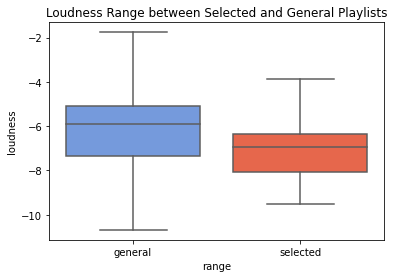

In [283]:
# Range of loudness

important_loudness_range = average_loudness_and_speechiness_by_playlist[average_loudness_and_speechiness_by_playlist
                                             .playlist_id.isin(loudness_playlists_tolist)][['playlist_id', 'loudness']].copy()

important_loudness_range['range'] = 'selected'

general_loudness_range = average_loudness_and_speechiness_by_playlist[['playlist_id', 'loudness']].copy()

general_loudness_range['range'] = 'general'

sns.boxplot(data = pd.concat([general_loudness_range, important_loudness_range]), 
            y='loudness', x='range', showfliers=False, palette=['#6495ED', '#FF5733'])
plt.title('Loudness Range between Selected and General Playlists')
plt.savefig('./Interpretability_PCA/loudness.png',  bbox_inches='tight')

In [269]:
# Range of speechiness

average_loudness_and_speechiness_by_playlist[average_loudness_and_speechiness_by_playlist
                                             .playlist_id.isin(speechiness_playlists_tolist)][['playlist_id', 'speechiness']]

,playlist_id,speechiness
207,0DXoY83tBvgWkd8QH49yAI,0.080133
2103,23VtON0Vk3Ulq27yotuV7T,0.131150
2270,2D0r3pA7EJcEjqx0ieIStb,0.086300
3297,37i9dQZEVXbKCF6dqVpDkS,0.086300
3515,37i9dQZF1DWXqcBHh7a68E,0.086300
3523,37i9dQZF1DWY24WaVcCqqH,0.086300
4648,3b4OsO3IhF3zUHIbYcAlBx,0.086300
4694,3dvQ8vcjBoLqjTz8Eefjhv,0.190750
4846,3mNz8BzJglA5EFFbs3f6dX,0.068100
4916,3qKdmMcYTNAYh7HPLNI2Kj,0.086300


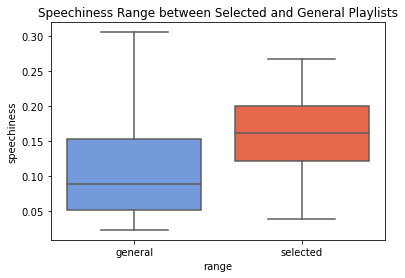

In [282]:
# Range of speechiness

important_speechiness_range = average_loudness_and_speechiness_by_playlist[average_loudness_and_speechiness_by_playlist
                                             .playlist_id.isin(loudness_playlists_tolist)][['playlist_id', 'speechiness']].copy()

important_speechiness_range['range'] = 'selected'

general_speechiness_range = average_loudness_and_speechiness_by_playlist[['playlist_id', 'speechiness']].copy()

general_speechiness_range['range'] = 'general'

sns.boxplot(data = pd.concat([general_speechiness_range, important_speechiness_range]), 
            y='speechiness', x='range', showfliers=False, palette=['#6495ED', '#FF5733'])
plt.title('Speechiness Range between Selected and General Playlists')
plt.savefig('./Interpretability_PCA/speechiness.png',  bbox_inches='tight')